In [1]:
import torch
from torch import Tensor
from typing import Optional
from torch.optim import Optimizer
from torch.optim.lr_scheduler import LRScheduler
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.optim import AdamW
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd
import yaml
import json
import os
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from PIL import Image
import numpy as np
import seaborn as sns
    

In [50]:
DEVICE = torch.device('cuda')
IMAGE_PATH = {}
SUBMISSION = None
LABELS = None
with open('../dirs.yaml', 'r') as file:
    dirs = yaml.safe_load(file)['homework-2']
    IMAGE_PATH['train'] = dirs['image-path']['train']
    IMAGE_PATH['test'] = dirs['image-path']['test']
    SUBMISSION = pd.read_csv(dirs['submission'])
    with open(dirs['labels']) as label_file:    
        LABELS = json.load(label_file)

In [52]:
SUBMISSION

,id,label
0,c41628b1-4781-4392-ac8d-6bfe981f73f9,0
1,f114acb3-fe18-478b-a19a-1f4cbe098851,0
2,d952ecfe-750c-44b2-96c2-1cac1a4ee146,0
3,2c14ec77-44ca-4b3c-b470-96286411c617,0
4,712c3ce9-750a-4cc4-8f94-f8033c31cb2c,0
...,...,...
844,ec8dd411-83cc-44f8-8f8b-aa73a4ca000d,0
845,68ad16ee-d556-4b77-83a7-9eb687e9d92c,0
846,ca069c6b-9c33-4a82-872a-2b91144be386,0
847,8643c18d-cd8c-4fa5-8a7a-931e97ba2add,0


In [ ]:
class ModelTrainer:
    def __init__(self,
                 num_epochs: int,
                 device: torch.device):
        self.num_epochs = num_epochs
        self.model = None
        self.train_loss_history = []
        self.test_loss_history = []
        self.train_acc_history = []
        self.test_acc_history = []
        self.train_f1_history = []
        self.test_f1_history = []
        self.device = device

    def __call__(self,
                 train_dataloader: DataLoader,
                 model: nn.Module,
                 optimizer: Optimizer,
                 criterion: nn.Module,
                 test_dataloader: Optional[DataLoader] = None,
                 scheduler: Optional[LRScheduler] = None) -> tuple:

        self.model = model.to(self.device)
        self.model.train()

        self.train_loss_history = []
        self.test_loss_history = []
        self.train_acc_history = []
        self.test_acc_history = []
        self.train_f1_history = []
        self.test_f1_history = []

        with tqdm(total=len(train_dataloader) * self.num_epochs, unit="batch") as pbar:
            for epoch in range(self.num_epochs):
                running_loss = 0.0
                y_true_train, y_pred_train = [], []

                for xb, yb in train_dataloader:
                    xb, yb = xb.to(self.device), yb.to(self.device)

                    optimizer.zero_grad()
                    outputs = model(xb)
                    loss = criterion(outputs, yb)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item()

                    _, predicted = torch.max(outputs.data, 1)
                    y_true_train.extend(yb.cpu().numpy())
                    y_pred_train.extend(predicted.cpu().numpy())

                    pbar.set_postfix({
                        "Epoch": f"{epoch+1}/{self.num_epochs}",
                        "Loss": f"{loss.item():.4f}"
                    })
                    pbar.update()

                train_acc = accuracy_score(y_true_train, y_pred_train)
                train_f1 = f1_score(y_true_train, y_pred_train, average="micro")

                self.train_acc_history.append(train_acc)
                self.train_f1_history.append(train_f1)

                if test_dataloader is not None:
                    test_loss, test_acc, test_f1 = self.test(test_dataloader)
                    self.test_loss_history.append(test_loss)
                    self.test_acc_history.append(test_acc)
                    self.test_f1_history.append(test_f1)
                else:
                    self.test_loss_history.append(0.0)
                    self.test_acc_history.append(0.0)
                    self.test_f1_history.append(0.0)

                avg_epoch_loss = running_loss / len(train_dataloader)
                self.train_loss_history.append(avg_epoch_loss)

                self.model.train()

                pbar.set_postfix({
                    "Epoch Loss": f"{avg_epoch_loss:.4f}",
                    "Train F1": f"{train_f1:.4f}",
                    "Test F1": f"{self.test_f1_history[-1]:.4f}" if test_dataloader else "N/A"
                })

                if scheduler is not None:
                    scheduler.step()

            pbar.close()

        output = ""
        metric_names = ["loss", "accurancy", "F1 score"]
        train_metrics = (self.train_loss_history[-1],
                         self.train_acc_history[-1],
                         self.train_f1_history[-1])
        if test_dataloader is not None:
            test_metrics = (self.test_loss_history[-1],
                            self.test_acc_history[-1],
                            self.test_f1_history[-1])
            for metric_name, train_metric, test_metric in zip(metric_names, train_metrics, test_metrics):
                output += f"{metric_name}:\n   train:{train_metric}, test:{test_metric}\n\n"
            print(output)
            
            return (
                (self.train_loss_history[-1], self.test_loss_history[-1]),
                (self.train_acc_history[-1], self.test_acc_history[-1]),
                (self.train_f1_history[-1], self.test_f1_history[-1]),
            )
            
        for metric_name, train_metric in zip(metric_names, train_metrics):
                output += f"{metric_name}:{train_metric}\n"
        print(output)   
        

        return self.train_loss_history[-1], self.train_acc_history[-1], self.train_f1_history[-1]

    def test(self, dataloader: DataLoader) -> tuple:
        self.model.eval()
        running_loss = 0.0
        y_true, y_pred = [], []

        criterion = nn.CrossEntropyLoss()

        with torch.no_grad():
            for xb, yb in dataloader:
                xb, yb = xb.to(self.device), yb.to(self.device)
                outputs = self.model(xb)
                loss = criterion(outputs, yb)
                running_loss += loss.item()

                _, predicted = torch.max(outputs.data, 1)
                y_true.extend(yb.cpu().numpy())
                y_pred.extend(predicted.cpu().numpy())

        avg_loss = running_loss / len(dataloader)
        accuracy = accuracy_score(y_true, y_pred)
        f1 = f1_score(y_true, y_pred, average="micro")

        return avg_loss, accuracy, f1

    def plot_loss_history(self, num_last_epoch: Optional[int] = None):
        if num_last_epoch is None:
            start_epoch = 0
        else:
            start_epoch = len(self.train_loss_history) - num_last_epoch

        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        axes[0].plot(self.train_loss_history[start_epoch:], label="Train Loss", marker='o')
        axes[0].plot(self.test_loss_history[start_epoch:], label="Test Loss", marker='o')
        axes[0].set_title("Loss over Epochs")
        axes[0].legend()
        axes[0].grid(True)

        axes[1].plot(self.train_acc_history[start_epoch:], label="Train Accuracy", marker='o')
        axes[1].plot(self.test_acc_history[start_epoch:], label="Test Accuracy", marker='o')
        axes[1].set_title("Accuracy over Epochs")
        axes[1].legend()
        axes[1].grid(True)

        axes[2].plot(self.train_f1_history[start_epoch:], label="Train F1", marker='o')
        axes[2].plot(self.test_f1_history[start_epoch:], label="Test F1", marker='o')
        axes[2].set_title("F1-score over Epochs")
        axes[2].legend()
        axes[2].grid(True)

        plt.tight_layout()
        plt.show()


In [53]:
def predict(model: nn.Module,
            transform: transforms.Compose,
            output_path: str = 'predict.csv'):
    ids = SUBMISSION['id'].to_list()
    model.eval()
    labels = [0] * len(ids)
    model = model.to(DEVICE)
    for filename in os.listdir(IMAGE_PATH['test']):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            img_id = filename.split(".")[0]
            idx = ids.index(img_id)
            img_path = os.path.join(IMAGE_PATH['test'], filename)
            img = Image.open(img_path).convert("RGB")
            img = transform(img).unsqueeze(0).to(DEVICE)
            pred = model(img).argmax(1).item()
            labels[idx] = pred

    pd.DataFrame({'id': ids, 'label': labels}).to_csv(output_path, index=False)

# Попытка решить задачу "в лоб"

In [ ]:
transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

train = datasets.ImageFolder(
    root=IMAGE_PATH['train'],
    transform=transform
)
train.class_to_idx = LABELS

test = [f for f in os.listdir(IMAGE_PATH['test'])
        if f.lower().endswith(('.png', '.jpg', '.jpeg'))]


In [29]:
train_dataloader, test_dataloader = [DataLoader(data, batch_size=32, shuffle=False)
                                     for data in train_test_split(train, test_size=0.2, shuffle=True, random_state=42)]

/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


In [30]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool2d((4, 4))
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 18)
        )

    def forward(self, x: Tensor) -> Tensor:
        x = self.features(x)
        x = self.classifier(x)
        return x

In [31]:
model = Net()
optimizer = AdamW(model.parameters(), lr=5e-3, weight_decay=7e-3)
criterion = nn.CrossEntropyLoss()

trainer = ModelTrainer(num_epochs=30, device=DEVICE)
trainer(train_dataloader,
        model,
        optimizer,
        criterion,
        test_dataloader=test_dataloader)


100%|██████████| 2190/2190 [02:51<00:00, 12.75batch/s, Epoch Loss=0.9948, Train F1=0.6672, Test F1=0.4751]

loss:
   train:0.994837565781319, test:1.9814196636802273

accurancy:
   train:0.6672384219554031, test:0.4751286449399657

F1 score:
   train:0.6672384219554031, test:0.4751286449399657




((0.994837565781319, 1.9814196636802273),
 (0.6672384219554031, 0.4751286449399657),
 (0.6672384219554031, 0.4751286449399657))

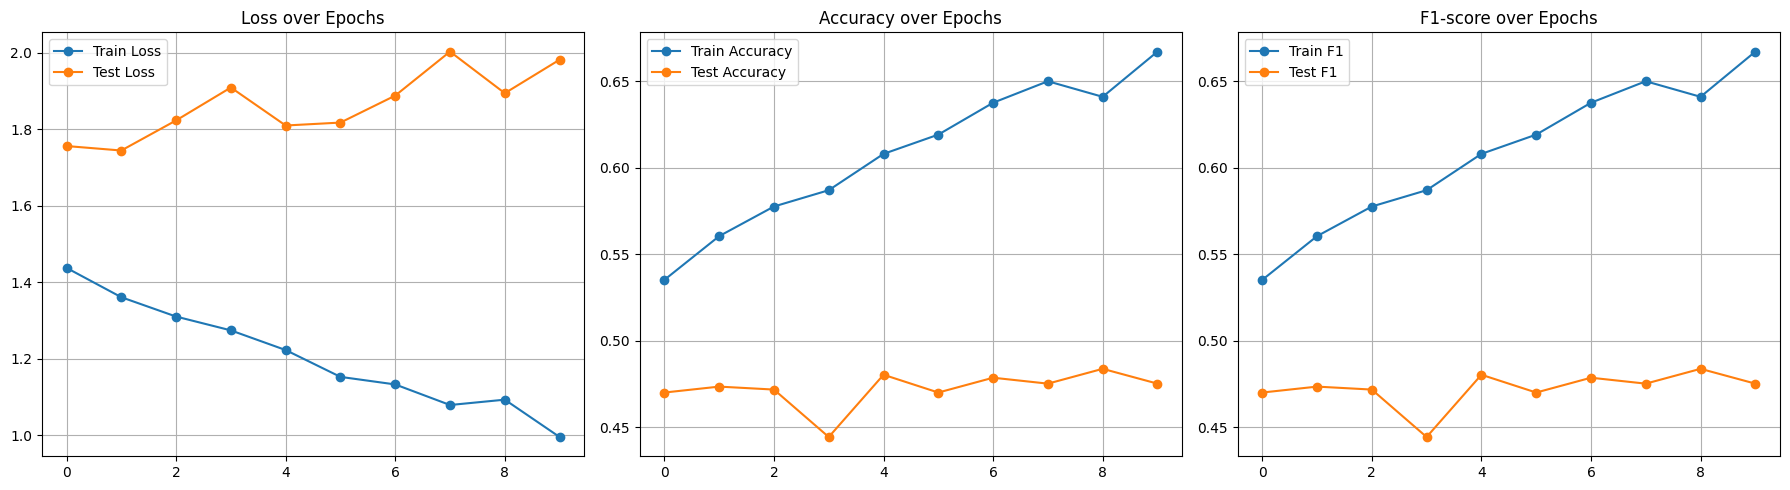

In [32]:
trainer.plot_loss_history(10)

**Вывод:** В условиях соревнования сказано, что можно использовать другие модели => лучше будет уже использовать хорошую готовую модели (к примеру, ResNet), которая будет, скорее всего, работать лучше, чем данная модель.

# Анализ датасета

## Распределение количества изображений по классам

/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


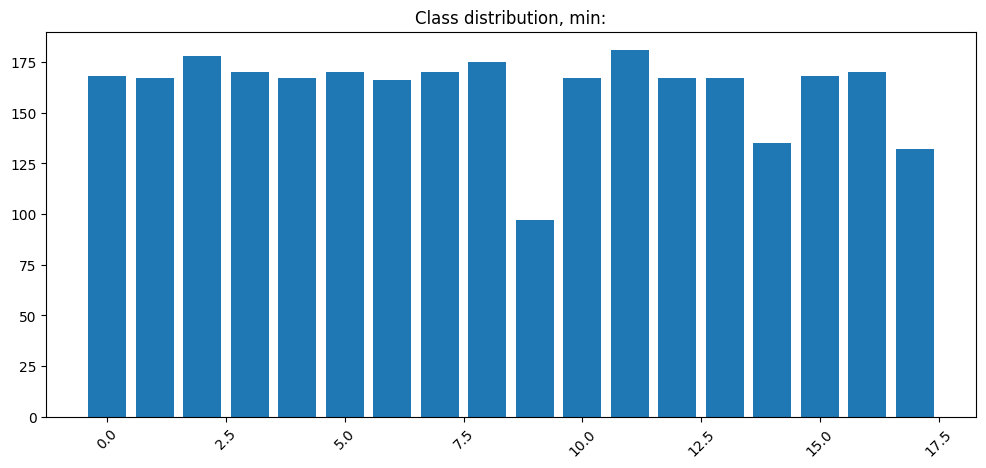

In [7]:
from collections import Counter
loader = DataLoader(train, batch_size=1, shuffle=False)

counts = Counter()

for _, label in loader:
    label = label.item()
    counts[label] += 1
    
names = list(counts.keys())
values = list(counts.values())

plt.figure(figsize=(12, 5))
plt.bar(names, values)
plt.xticks(rotation=45)
plt.title(f"Class distribution, min:")
plt.show()


In [51]:
pd.DataFrame([values], index=["count"])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
count,168,167,178,170,167,170,166,170,175,97,167,181,167,167,135,168,170,132


In [43]:
values = np.array(values)
pd.DataFrame({
    "mean": values.mean(),
    "std": values.std(),
    "min": values.min(),
    "max": values.max(),
    "scope": values.max() - values.min()
}, index=[0])

,mean,std,min,max,scope
0,161.944444,19.873132,97,181,84


**Вывод**: В целом, классы можно нозвать достаточно сбалансированнаыми, за исключением `9` и `13`, число картинок в них явно меньше => необходимо использовать аугментацию

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
    ])

train = datasets.ImageFolder(
    root=IMAGE_PATH['train'],
    transform=transform
)
train.class_to_idx = LABELS

## Базовые метрики

In [70]:
brightness = []
contrast = []
widths = []
heights = []

for img in train:
    brightness.append(img[0].mean().item())
    contrast.append(img[0].std().item())
    size = img[0].shape[1:]
    widths.append(size[0])
    heights.append(size[1])

print(f"Средняя яркость: {np.mean(brightness):.3f}")
print(f"Средний контраст: {np.mean(contrast):.3f}")
print(f"Диапазон яркости: {np.min(brightness):.3f}, {np.max(brightness):.3f}")
print(f"Диапазон контраста: {np.min(contrast):.3f}, {np.max(contrast):.3f}")
print(f"Средний размер:{np.mean(widths):.3f} x {np.mean(heights):.3f}")
print(f"Минимум:{np.min(widths)} x {np.min(heights)}")
print(f"Максимум: {np.max(widths)} x {np.max(heights)}")

/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Средняя яркость: 0.531
Средний контраст: 0.282
Диапазон яркости: 0.044, 0.958
Диапазон контраста: 0.052, 0.491
Средний размер:392.045 x 431.227
Минимум:77 x 63
Максимум: 6408 x 3876


**Вывод:** у каждой метрии достотачно высокие диапазоны

## Воспользуемся Resnet18 для анализма

In [95]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

train = datasets.ImageFolder(
    root=IMAGE_PATH['train'],
    transform=transform
)
train.class_to_idx = LABELS

/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


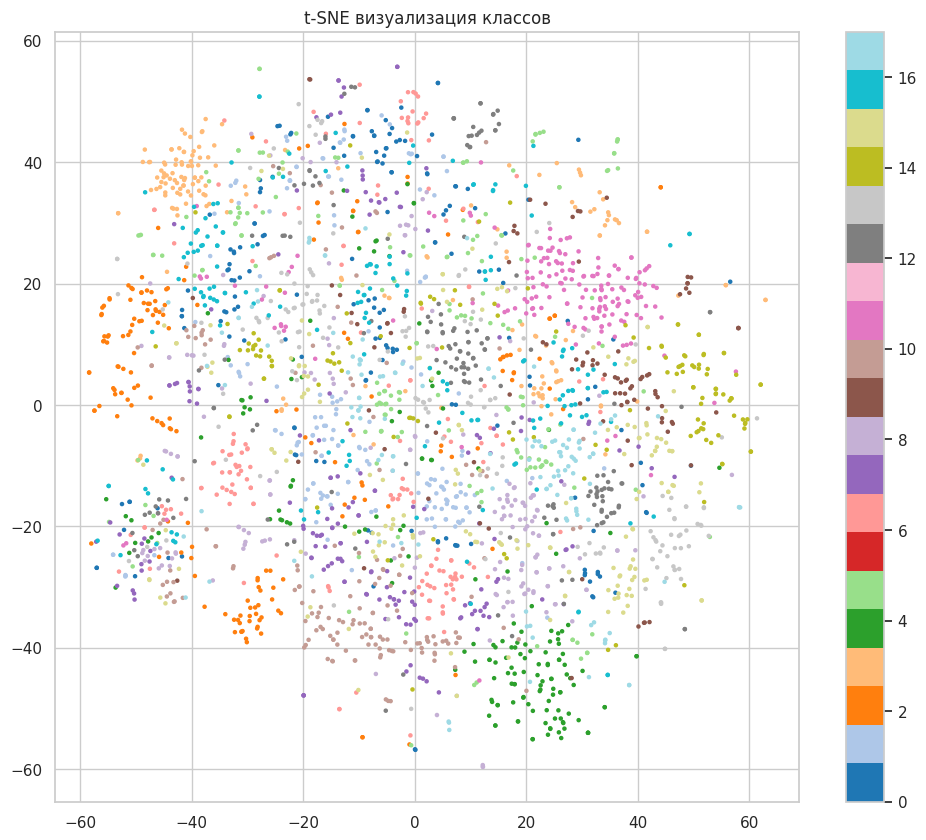

In [96]:
from torchvision.models import resnet18
from sklearn.manifold import TSNE

model = resnet18(pretrained=True).to(DEVICE)
model.fc = torch.nn.Identity()
model.eval()

embeddings = []
labels_np = []

with torch.no_grad():
    for img, label in train:
        emb = model(img.to(DEVICE).unsqueeze(0)).squeeze().to('cpu').numpy()
        embeddings.append(emb)
        labels_np.append(label)

embeddings = np.array(embeddings)

tsne = TSNE(n_components=2, perplexity=30)
X_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(12, 10))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels_np, s=5, cmap="tab20")
plt.colorbar()
plt.title("t-SNE визуализация классов")
plt.show()


/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


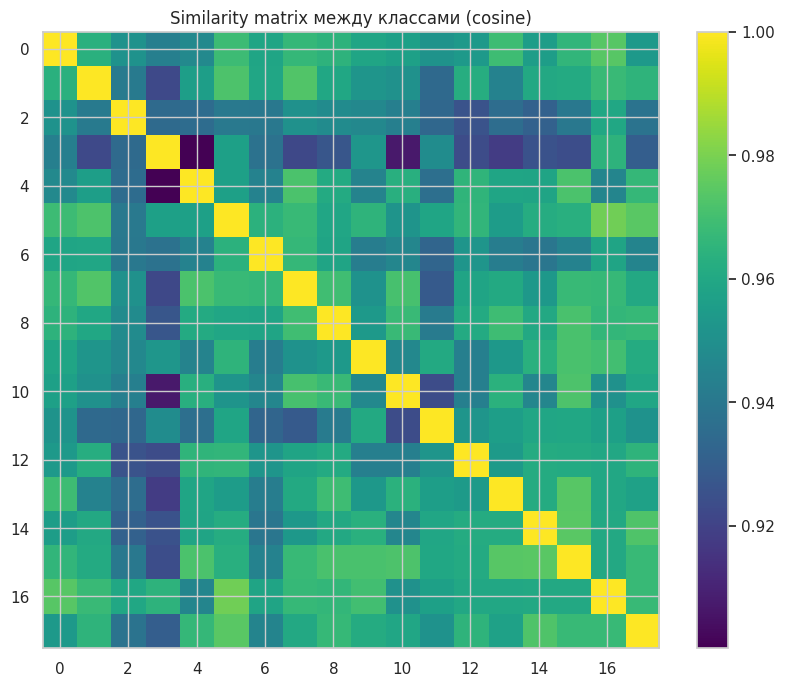

In [97]:
from sklearn.metrics.pairwise import cosine_similarity

class_means = {}

for c in range(18):
    class_embs = [embeddings[i] for i in range(len(embeddings)) if train[i][1] == c]
    class_means[c] = np.mean(class_embs, axis=0)

mean_vectors = np.stack([class_means[c] for c in range(18)])
sim_matrix = cosine_similarity(mean_vectors)

plt.figure(figsize=(10, 8))
plt.imshow(sim_matrix, cmap='viridis')
plt.colorbar()
plt.title("Similarity matrix между классами (cosine)")
plt.show()

/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


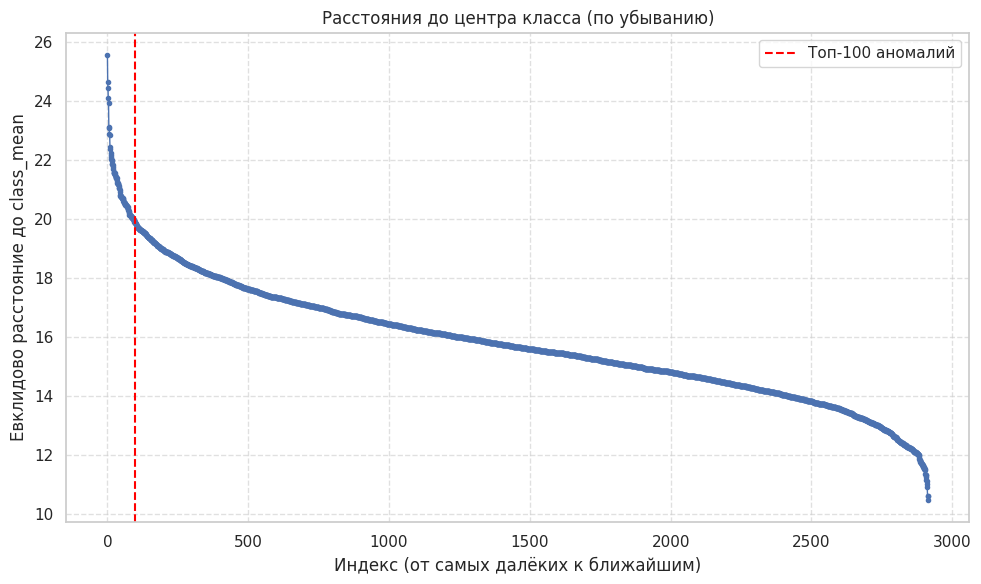

In [ ]:
N = 100
distances = []
for idx in range(len(embeddings)):
    c = train[idx][1]
    dist = np.linalg.norm(embeddings[idx] - class_means[c])
    distances.append(dist)

distances_sorted = np.sort(distances)[::-1]

plt.figure(figsize=(10, 6))
plt.plot(distances_sorted, marker='o', markersize=3, linestyle='-', linewidth=1)
plt.axvline(x=N-1, color='red', linestyle='--', label=f'Топ-{N} аномалий')
plt.title('Расстояния до центра класса (по убыванию)')
plt.xlabel('Индекс (от самых далёких к ближайшим)')
plt.ylabel('Евклидово расстояние до class_mean')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


**Выводы:**
 1. Из первого графика можно сделать вывод, что, в целом, сложно выделить какие-то определенные классы.
 2. Из второго графика можно сделать вывод, что, в целом классы очень похожи. Скорее всего, это связано со специфичной областью классификации
 3. В данных, относительно "серединных картинок" имеются выбросы 

/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  7%|▋         | 50/690 [00:21<04:26,  2.41batch/s, Epoch=2/15, Loss=2.8448]                        /home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 13%|█▎        | 93/690 [00:40<0

loss:1.6025130178617395
accurancy:0.6967409948542024
F1 score:0.6967409948542024



/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


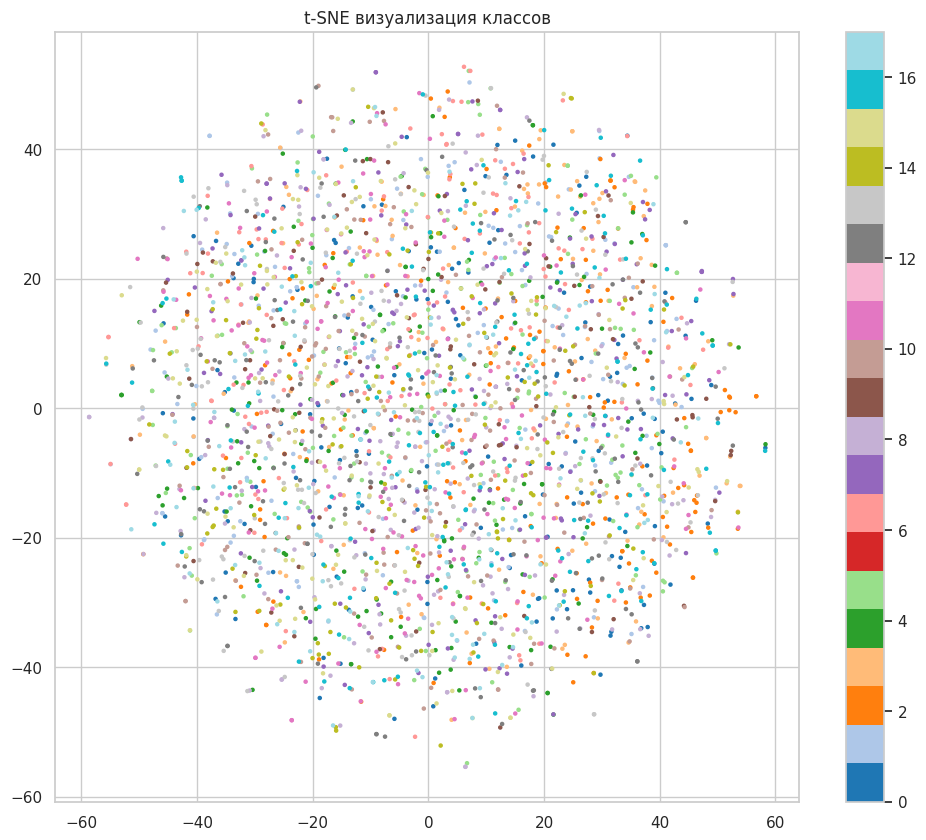

In [105]:
model = resnet18(pretrained=True).to(DEVICE)
for param in model.parameters():
    param.requires_grad = False
num_features = model.fc.in_features
num_classes = 18
model.fc = nn.Linear(num_features, num_classes)
model.eval()

trainer = ModelTrainer(15, DEVICE)
trainer(DataLoader(train, batch_size=64, shuffle=True),
        model,
        AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4),
        nn.CrossEntropyLoss())
model = trainer.model

embeddings = []
labels_np = []

with torch.no_grad():
    for img, label in train:
        emb = model(img.to(DEVICE).unsqueeze(0)).squeeze().to('cpu').numpy()
        embeddings.append(emb)
        labels_np.append(label)

embeddings = np.array(embeddings)

tsne = TSNE(n_components=2, perplexity=30)
X_2d = tsne.fit_transform(embeddings)

plt.figure(figsize=(12, 10))
plt.scatter(X_2d[:,0], X_2d[:,1], c=labels_np, s=5, cmap="tab20")
plt.colorbar()
plt.title("t-SNE визуализация классов")
plt.show()


# Трансферное обучение

## Преобразования датасета


In [68]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomApply([
        transforms.GaussianBlur(3)
    ], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

train = datasets.ImageFolder(
    root=IMAGE_PATH['train'],
    transform=transform
)
train.class_to_idx = LABELS

In [69]:
from torch.utils.data import WeightedRandomSampler, Subset
values = np.array(values)
total = values.sum()
weights = values.mean() / values

sample_weights = [weights[label] for _, label in train.samples]

indices = list(range(len(train)))
train_idx, test_idx = train_test_split(indices, test_size=0.2, shuffle=True, random_state=42)

train_data = Subset(train, train_idx)
test_data = Subset(train, test_idx)

sampler = WeightedRandomSampler([sample_weights[i] for i in train_idx], num_samples=len(train_data), replacement=True)
train_dataloader = DataLoader(train_data, batch_size=64, sampler=sampler)
test_dataloader = DataLoader(test_data, batch_size=64)




In [19]:
def plot_confusion_matrix(model: nn.Module):
    y_true, y_pred = [], []
    model = model.eval()
    with torch.no_grad():
        for xb, yb in DataLoader(train, batch_size=32):
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            outputs = model(xb)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(yb.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.title("Confusion Matrix")
    plt.show()

## Resnet18

In [20]:
from torchvision.models import resnet18
model = resnet18(pretrained=True).to(DEVICE)
for param in model.parameters():
    param.requires_grad = False
num_features = model.fc.in_features
num_classes = 18
model.fc = nn.Linear(num_features, num_classes)

trainer = ModelTrainer(15, DEVICE)
trainer(train_dataloader,
        model,
        AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4),
        nn.CrossEntropyLoss(),
        test_dataloader=test_dataloader)
model = trainer.model

/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  7%|▋         | 37/555 [00:22<04:12,  2.06batch/s, Epoch=1/15, Loss=2.8678]/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  7%|▋         | 37/555 [00:26<04:12,  2.06batch/s, Epoc

loss:
   train:1.8098847704964716, test:1.8335352659225463

accurancy:
   train:0.6483704974271012, test:0.6123499142367067

F1 score:
   train:0.6483704974271012, test:0.6123499142367067




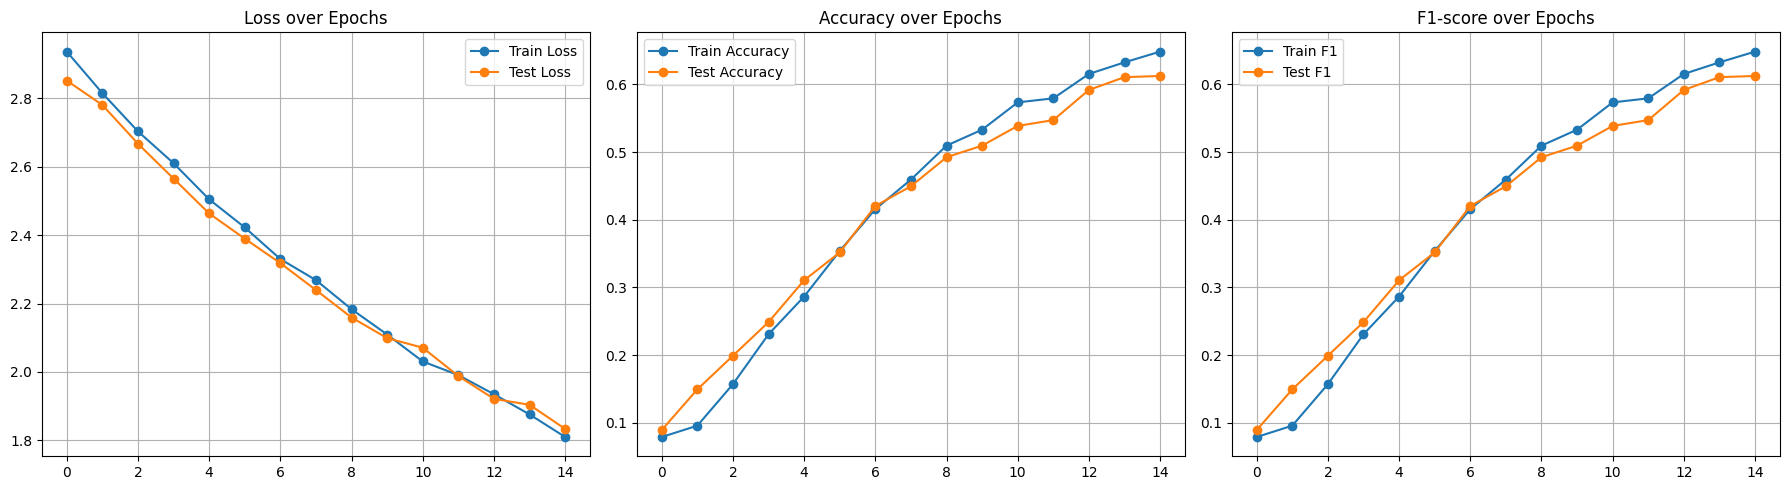

In [21]:
trainer.plot_loss_history()

/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


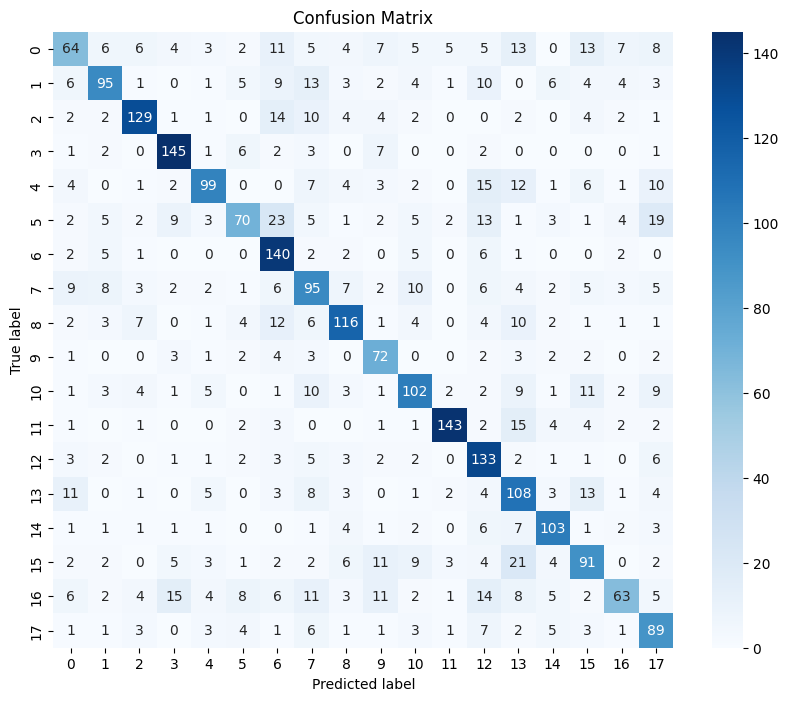

In [22]:
plot_confusion_matrix(model)

## Resnet50

In [23]:
from torchvision.models import resnet50
model = resnet50(pretrained=True).to(DEVICE)
for param in model.parameters():
    param.requires_grad = False
num_features = model.fc.in_features
num_classes = 18
model.fc = nn.Linear(num_features, num_classes)

trainer = ModelTrainer(15, DEVICE)
trainer(train_dataloader,
        model,
        AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4),
        nn.CrossEntropyLoss(),
        test_dataloader=test_dataloader)
model = trainer.model

/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  1%|          | 4/555 [00:02<06:13,  1.47batch/s, Epoch=1/15, Loss=2.9040]/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  7%|▋         | 37/555 [00:25<05:12,  1.66batch/s, Epoch

loss:
   train:1.3276811483744029, test:1.417961883544922

accurancy:
   train:0.7851629502572899, test:0.7049742710120068

F1 score:
   train:0.7851629502572899, test:0.7049742710120068




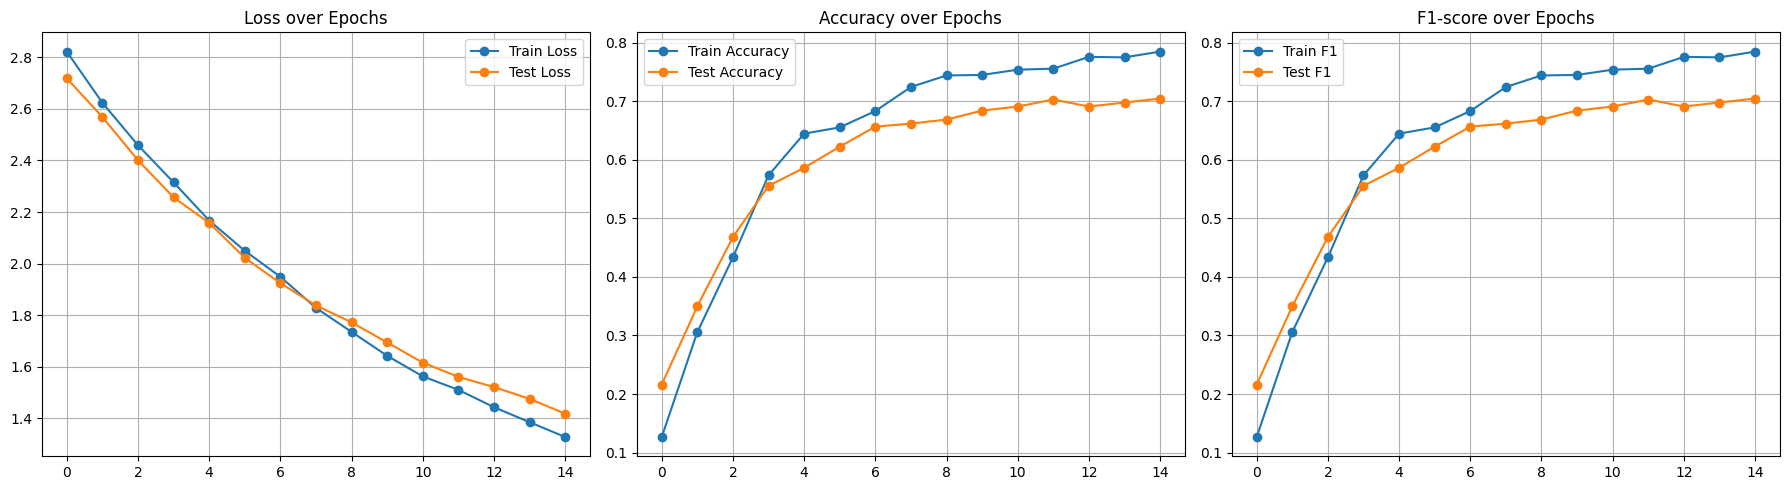

In [24]:
trainer.plot_loss_history()

/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


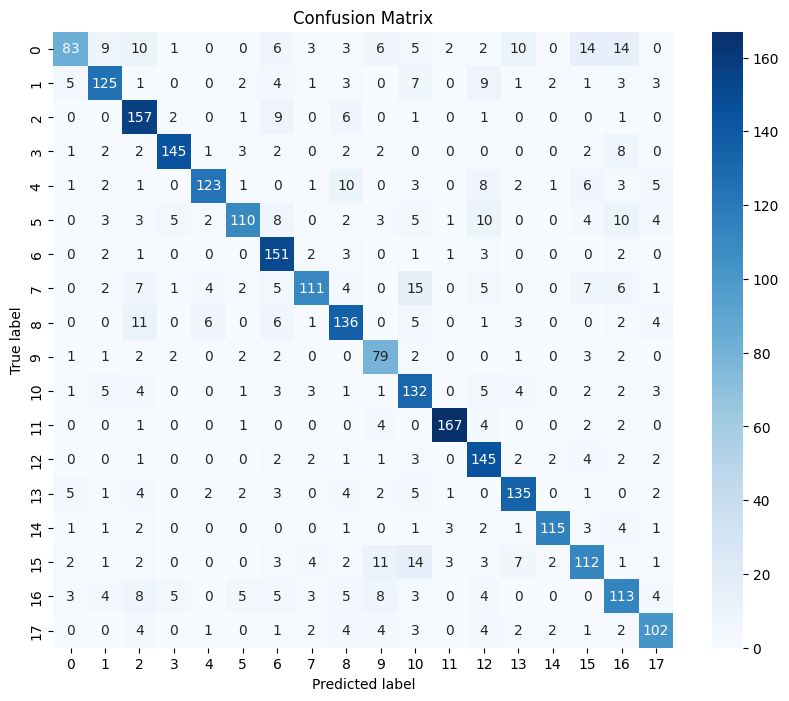

In [25]:
plot_confusion_matrix(model)

## EfficientNetB2

In [36]:
from torchvision.models import efficientnet_b2
model = efficientnet_b2(pretrained=True).to(DEVICE)
for param in model.parameters():
    param.requires_grad = False
num_features = model.classifier[1].in_features
num_classes = 18
model.classifier[1] = nn.Linear(num_features, num_classes)

trainer = ModelTrainer(15, DEVICE)
trainer(train_dataloader,
        model,
        AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4),
        nn.CrossEntropyLoss(),
        test_dataloader=test_dataloader)
model = trainer.model

/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/555 [00:00<?, ?batch/s]/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  7%|▋         | 37/555 [00:23<04:21,  1.98batch/s, Epoch=1/15, Loss=2.7409]

loss:
   train:1.8396710511800405, test:1.919023036956787

accurancy:
   train:0.7216981132075472, test:0.7101200686106347

F1 score:
   train:0.7216981132075472, test:0.7101200686106347




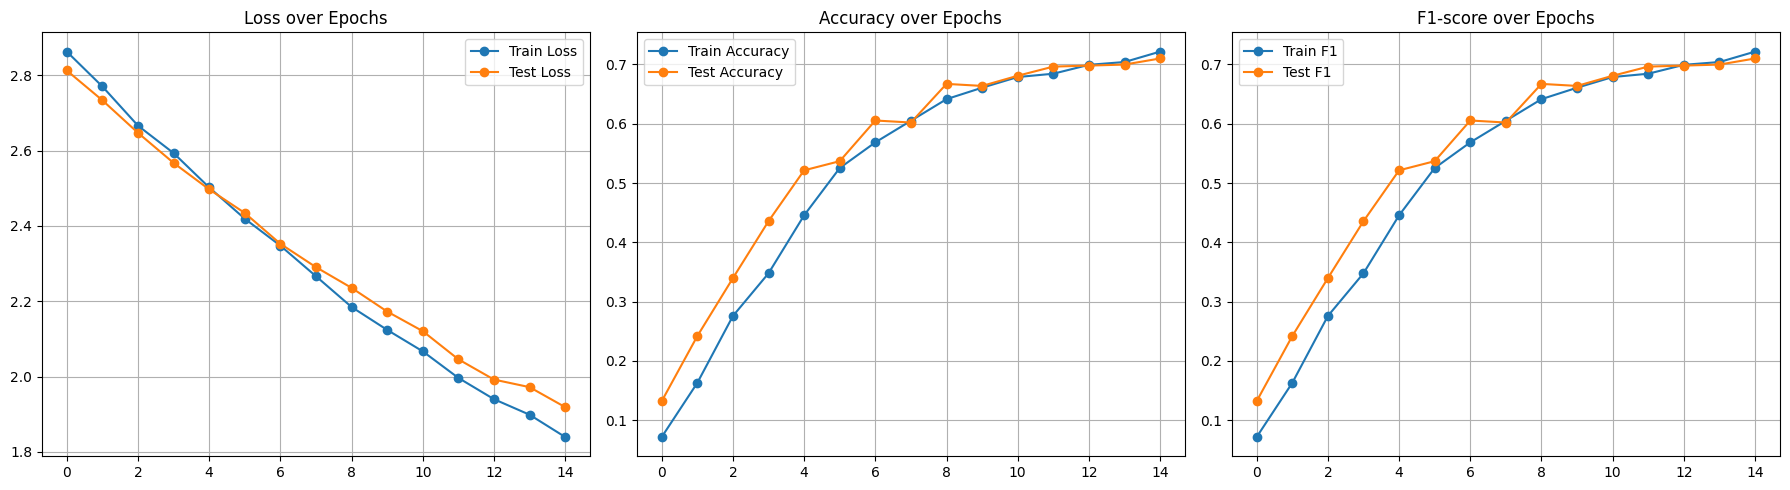

In [37]:
trainer.plot_loss_history()

/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


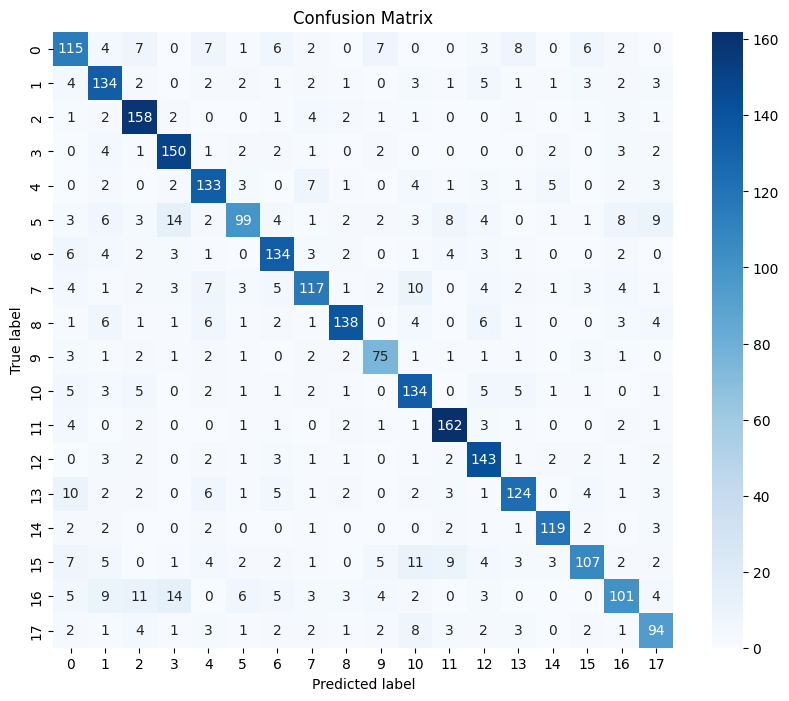

In [38]:
plot_confusion_matrix(model)

## ConvnextTiny

In [39]:
from torchvision.models import convnext_tiny
model = convnext_tiny(pretrained=True).to(DEVICE)
for param in model.parameters():
    param.requires_grad = False
num_features = model.classifier[2].in_features
num_classes = 18
model.classifier[2] = nn.Linear(num_features, num_classes)

trainer = ModelTrainer(15, DEVICE)
trainer(train_dataloader,
        model,
        AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4),
        nn.CrossEntropyLoss(),
        test_dataloader=test_dataloader)
model = trainer.model

/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/convnext_tiny-983f1562.pth" to /home/victor/.cache/torch/hub/checkpoints/convnext_tiny-983f1562.pth


100%|██████████| 109M/109M [00:10<00:00, 11.2MB/s] 
  3%|▎         | 19/555 [00:15<06:55,  1.29batch/s, Epoch=1/15, Loss=2.8785]/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  7%|▋         | 37/555 [00:30<07:46,  1.11batch/s, Epoch=1/15, Loss=2.8324]/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  7%|▋         | 39/555 [00:40<21:22,  2.49s/batch, Epoch=2/15, Loss=2.7772]                           /home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 13%|█▎        | 74/555 [01:08<05:41,  1.41batch/s, Epoch=2/15, Loss=2.6212]/home/victor/anacond

loss:
   train:1.5843832170641101, test:1.6038129448890686

accurancy:
   train:0.7388507718696398, test:0.7032590051457976

F1 score:
   train:0.7388507718696398, test:0.7032590051457976




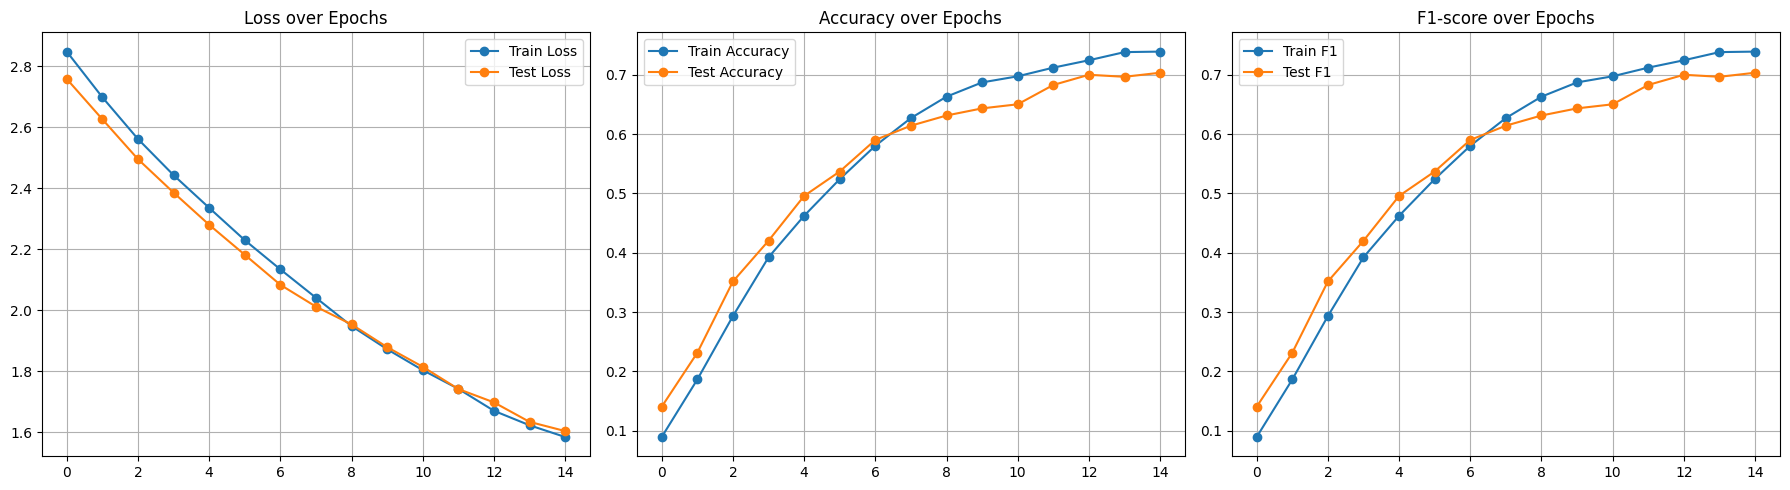

In [40]:
trainer.plot_loss_history()

/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


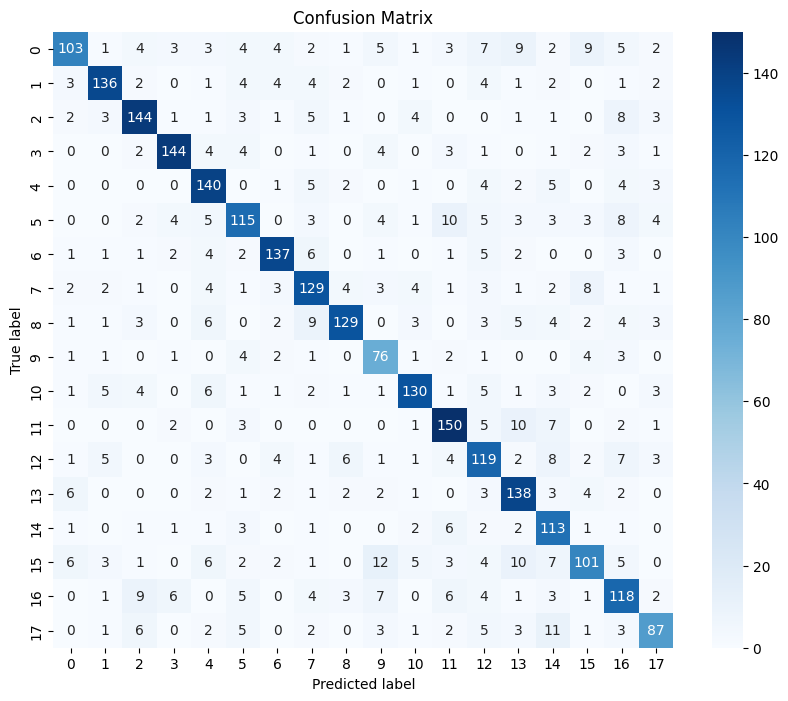

In [41]:
plot_confusion_matrix(model)

## Добавление CutMix и MixUp

In [75]:
class Mix:
    def __init__(self, alpha: float = 1.0, p: float = 0.7, mode: str = "both", num_classes: int = 18):
        self.alpha = alpha
        self.p = p
        self.mode = mode
        self.num_classes = num_classes

    def _lambda(self):
        lam = np.random.beta(self.alpha, self.alpha)
        return max(lam, 1 - lam)

    def __call__(self, batch):
        images = torch.stack([item[0] for item in batch])
        labels = torch.tensor([item[1] for item in batch])

        if np.random.rand() > self.p:
            return images, labels

        lam = self._lambda()
        idx = torch.randperm(images.size(0))

        if (self.mode == "mixup") or (self.mode == "both" and np.random.rand() < 0.5):
            images = lam * images + (1 - lam) * images[idx]

        else:
            B, C, H, W = images.size()
            cut_w = int(W * np.sqrt(1 - lam))
            cut_h = int(H * np.sqrt(1 - lam))
            cx = np.random.randint(W)
            cy = np.random.randint(H)

            x1 = np.clip(cx - cut_w // 2, 0, W)
            x2 = np.clip(cx + cut_w // 2, 0, W)
            y1 = np.clip(cy - cut_h // 2, 0, H)
            y2 = np.clip(cy + cut_h // 2, 0, H)

            images[:, :, y1:y2, x1:x2] = images[idx, :, y1:y2, x1:x2]

        return images, labels


In [76]:
mix_fn = Mix(alpha=0.8, p=0.7, mode="both", num_classes=18)

In [79]:
values = np.array(values)
total = values.sum()
weights = values.mean() / values

sample_weights = [weights[label] for _, label in train.samples]

indices = list(range(len(train)))
train_idx, test_idx = train_test_split(indices, test_size=0.2, shuffle=True, random_state=42)

train_data = Subset(train, train_idx)
test_data = Subset(train, test_idx)

sampler = WeightedRandomSampler([sample_weights[i] for i in train_idx], num_samples=len(train_data), replacement=True)
train_dataloader = DataLoader(train_data, batch_size=64, sampler=sampler, collate_fn=mix_fn)
test_dataloader = DataLoader(test_data, batch_size=64)




In [80]:
model = resnet50(pretrained=True).to(DEVICE)
for param in model.parameters():
    param.requires_grad = False
num_features = model.fc.in_features
num_classes = 18
model.fc = nn.Linear(num_features, num_classes)

trainer = ModelTrainer(15, DEVICE)
trainer(train_dataloader,
        model,
        AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4),
        nn.CrossEntropyLoss(),
        test_dataloader=test_dataloader)
model = trainer.model

  7%|▋         | 37/555 [00:26<05:35,  1.54batch/s, Epoch=1/15, Loss=2.8223]/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 10%|█         | 56/555 [00:45<05:48,  1.43batch/s, Epoch=2/15, Loss=2.8158]                           /home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 13%|█▎        | 74/555 [00:58<04:50,  1.66batch/s, Epoch=2/15, Loss=2.8101]/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 14%|█▍        | 80/555 [01:08<07:47,  1.02batch/s, Epoch=3/15, Loss=2.6065]                           /home/victor/anaconda3/envs/torch/lib/python3

loss:
   train:1.6979261346765466, test:1.5313864350318909

accurancy:
   train:0.6642367066895368, test:0.7032590051457976

F1 score:
   train:0.6642367066895368, test:0.7032590051457976




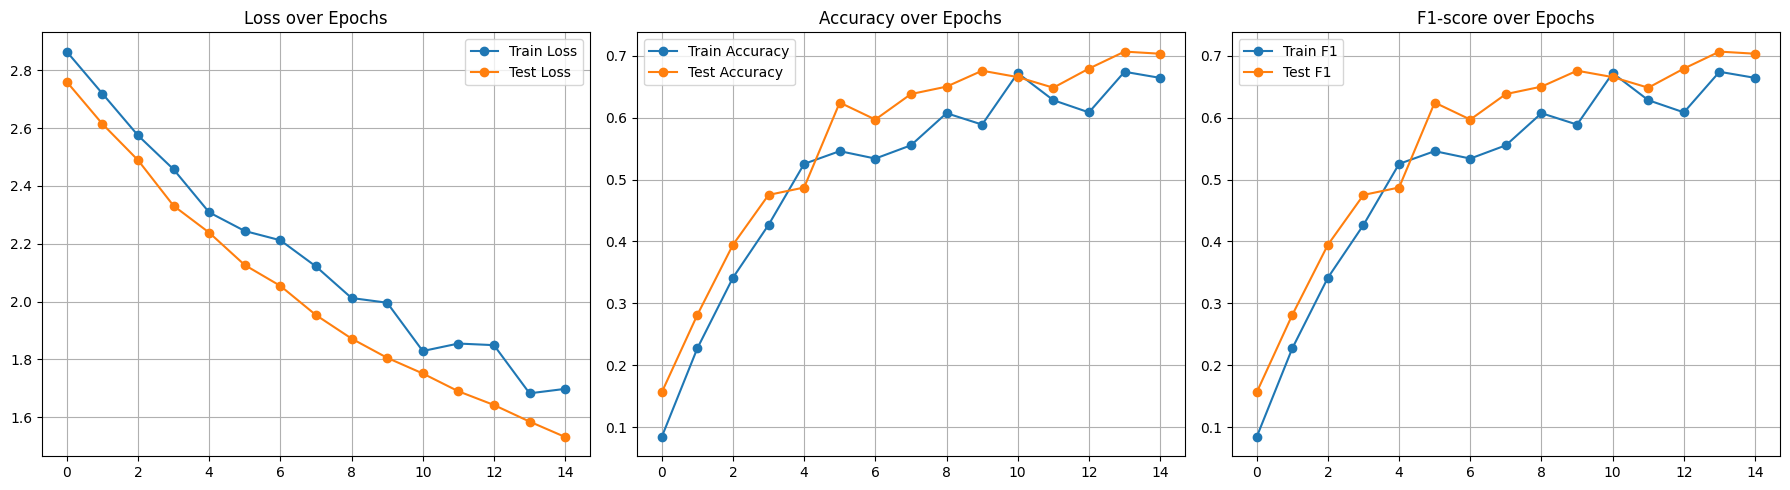

In [81]:
trainer.plot_loss_history()

/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


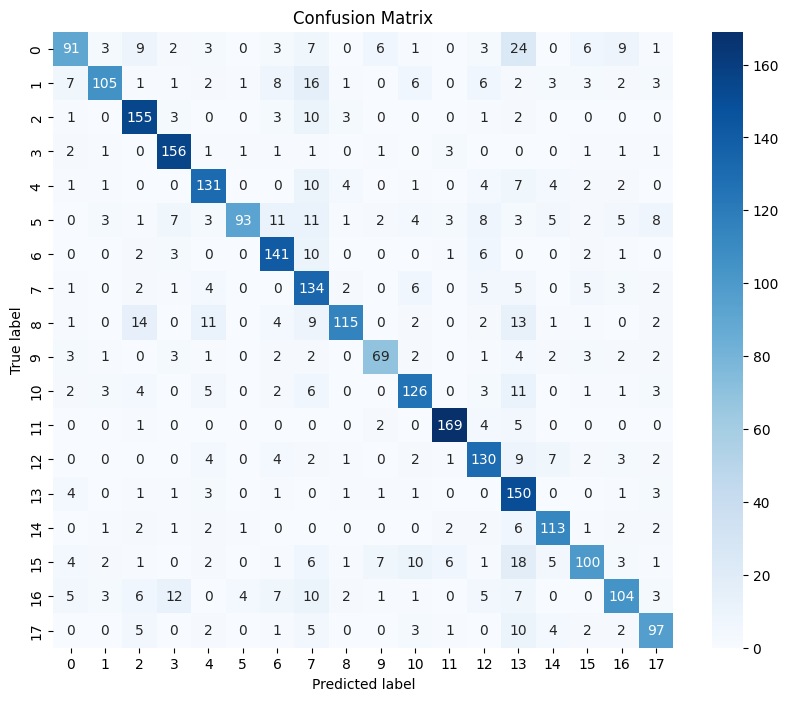

In [82]:
plot_confusion_matrix(model)

# Отправка ответов

## EfficientNetB2

In [83]:
test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

In [84]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.RandomApply([
        transforms.GaussianBlur(3)
    ], p=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
    ])

train = datasets.ImageFolder(
    root=IMAGE_PATH['train'],
    transform=train_transform
)
train.class_to_idx = LABELS

In [85]:
values = np.array(values)
total = values.sum()
weights = values.mean() / values

sample_weights = [weights[label] for _, label in train.samples]


sampler = WeightedRandomSampler([sample_weights[i] for i in train_idx], num_samples=len(train), replacement=True)
train_dataloader = DataLoader(train, batch_size=64, sampler=sampler)

In [ ]:

model = efficientnet_b2(pretrained=True).to(DEVICE)
for param in model.parameters():
    param.requires_grad = False
num_features = model.classifier[1].in_features
num_classes = 18
model.classifier[1] = nn.Linear(num_features, num_classes)

trainer = ModelTrainer(15, DEVICE)
trainer(train_dataloader,
        model,
        AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4),
        nn.CrossEntropyLoss())

predict(trainer.model, test_transform, "EfficientNetB2.csv")



/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  2%|▏         | 11/690 [00:07<07:55,  1.43batch/s, Epoch=1/15, Loss=2.8612]/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  7%|▋         | 46/690 [00:31<06:15,  1.7

loss:
   train:1.4617114559463833, test:2.0814975261688233

accurancy:
   train:0.755746140651801, test:0.6878216123499142

F1 score:
   train:0.755746140651801, test:0.6878216123499142




/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Resnet50

In [86]:
model = resnet50(pretrained=True).to(DEVICE)
for param in model.parameters():
    param.requires_grad = False
num_features = model.fc.in_features
num_classes = 18
model.fc = nn.Linear(num_features, num_classes)

trainer = ModelTrainer(15, DEVICE)
trainer(train_dataloader,
        model,
        AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4),
        nn.CrossEntropyLoss())

predict(trainer.model, test_transform, "Resnet.csv")

/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 2/690 [00:01<09:21,  1.23batch/s, Epoch=1/15, Loss=2.8294]/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  7%|▋         | 50/690 [00:37<08:01,  1.33batch/s, Epoch

loss:0.9813232240469559
accurancy:0.8205831903945111
F1 score:0.8205831903945111



/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


## Добавление Mix

In [87]:
values = np.array(values)
total = values.sum()
weights = values.mean() / values

sample_weights = [weights[label] for _, label in train.samples]


sampler = WeightedRandomSampler([sample_weights[i] for i in train_idx], num_samples=len(train), replacement=True)
train_dataloader = DataLoader(train, batch_size=64, sampler=sampler, collate_fn=mix_fn)

### Resnet50

In [88]:
model = resnet50(pretrained=True).to(DEVICE)
for param in model.parameters():
    param.requires_grad = False
num_features = model.fc.in_features
num_classes = 18
model.fc = nn.Linear(num_features, num_classes)

trainer = ModelTrainer(15, DEVICE)
trainer(train_dataloader,
        model,
        AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4),
        nn.CrossEntropyLoss())

predict(trainer.model, test_transform, "Resnet_MIX.csv")

/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  7%|▋         | 51/690 [00:36<07:52,  1.35batch/s, Epoch=2/15, Loss=2.5140]                        /home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 13%|█▎        | 92/690 [01:08<0

loss:1.270725147879642
accurancy:0.720754716981132
F1 score:0.720754716981132



/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### EfficientB2

In [89]:
model = efficientnet_b2(pretrained=True).to(DEVICE)
for param in model.parameters():
    param.requires_grad = False
num_features = model.classifier[1].in_features
num_classes = 18
model.classifier[1] = nn.Linear(num_features, num_classes)

trainer = ModelTrainer(15, DEVICE)
trainer(train_dataloader,
        model,
        AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4),
        nn.CrossEntropyLoss())

predict(trainer.model, test_transform, "EfficientNetB2_MIX.csv")

/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B2_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  7%|▋         | 51/690 [00:35<07:02,  1.51batch/s, Epoch=2/15, Loss=2.6886]                        /home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
 16%|█▌        | 1

loss:1.7461655606394229
accurancy:0.6425385934819897
F1 score:0.6425385934819897



/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


### ConvnextTiny

In [90]:
model = convnext_tiny(pretrained=True).to(DEVICE)
for param in model.parameters():
    param.requires_grad = False
num_features = model.classifier[2].in_features
num_classes = 18
model.classifier[2] = nn.Linear(num_features, num_classes)

trainer = ModelTrainer(15, DEVICE)
trainer(train_dataloader,
        model,
        AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4),
        nn.CrossEntropyLoss(),
        test_dataloader=test_dataloader)

predict(trainer.model, test_transform, "ConvnextTiny_MIX.csv")

/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ConvNeXt_Tiny_Weights.IMAGENET1K_V1`. You can also use `weights=ConvNeXt_Tiny_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  7%|▋         | 46/690 [00:39<09:02,  1.19batch/s, Epoch=1/15, Loss=2.6350]/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
  7%|▋         | 49/690 [00:50<21:44,  2.04s/b

loss:
   train:1.4835289820380833, test:2.1283294677734377

accurancy:
   train:0.7018867924528301, test:0.6535162950257289

F1 score:
   train:0.7018867924528301, test:0.6535162950257289




/home/victor/anaconda3/envs/torch/lib/python3.11/site-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
